# Word Embedding

A corpus of manually labeled comments - classifying each comment by its degree of toxicity is available on Kaggle. 

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Acquire the data

In [2]:
#!wget http://bit.do/deep_toxic_train -P data/

In [3]:
#!mv data/deep_toxic_train data/train.zip

In [4]:
#!cd data && unzip train.zip

In [5]:
train = pd.read_csv("data/train.csv")

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Import the required libraries

### Create the train and label datasets (X, y)

In [7]:
y_train = train.iloc[:,2:].values

In [8]:
x_train_series = train["comment_text"]

In [9]:
x_train_series.shape, y_train.shape

((159571,), (159571, 6))

## Using Spacy and Pre-trained Word Vectors

### Install the libraries

Install Spacy library

In [17]:
# Install SPACY 
#! pip install -U spacy

Install the large corpus of the English which has the word vectors

In [18]:
#! python -m spacy download en_core_web_lg

    100% |████████████████████████████████| 852.3MB 81.1MB/s 
  Running setup.py install for en-core-web-lg ... done

    Linking successful
    /opt/conda/lib/python3.6/site-packages/en_core_web_lg -->
    /opt/conda/lib/python3.6/site-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [12]:
# Needed only if we want to train our own word2vec
# !pip install --upgrade gensim

### Import the libraries

In [19]:
import spacy
#from gensim.models import Word2Vec

In [20]:
nlp = spacy.load('en_core_web_lg')

In [21]:
doc1 = nlp(x_train_series[1])
doc2 = nlp(x_train_series[2])

## Word vectors

In [22]:
for token in doc1[:5]:
    print(token.text, token.has_vector, token.vector_norm)

D'aww True 7.874731
! True 5.620569
He True 6.080851
matches True 5.9950457
this True 5.0461264


## Sentence vectors & similiarity

In [23]:
len(doc1.vector)

300

In [24]:
doc1.similarity(doc2)

0.8165169278874318

## Create the sentence embedding for learning

Lets create the embedding for the first 100 sentences

In [25]:
def get_vector(sentence):
    vector = nlp(sentence).vector
    return vector

In [26]:
get_vector(x_train_series[1]).shape

(300,)

In [27]:
x_train_series.iloc[0:10,]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [28]:
from tqdm import tqdm, tqdm_pandas
tqdm.pandas(desc="progress")

In [30]:
x_train_series = x_train_series.progress_apply(get_vector)

progress:  30%|██▉       | 47327/159571 [11:29<26:07, 71.62it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

progress:  69%|██████▉   | 109736/159571 [26:21<12:56, 64.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

progress: 100%|██████████| 159571/159571 [38:31<00:00, 69.03it/s]


In [48]:
x_train_series.shape

(159571,)

In [52]:
x_train = np.vstack(x_train_series)

In [53]:
x_train.shape

(159571, 300)

## Lets build a classifier

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [82]:
clf = Sequential()
clf.add(Dense(100, input_dim = 300, activation = "relu"))
clf.add(Dropout(0.25))
clf.add(Dense(50, activation = "relu"))
clf.add(Dropout(0.25))
clf.add(Dense(6, activation="sigmoid"))

In [83]:
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 306       
Total params: 35,456
Trainable params: 35,456
Non-trainable params: 0
_________________________________________________________________


In [84]:
clf.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [85]:
%timeit
history = clf.fit(x_train, y_train, batch_size=128, epochs = 20, validation_split = 0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 3s 23us/step - loss: 0.0858 - acc: 0.9721 - val_loss: 0.0575 - val_acc: 0.9791
Epoch 2/20
127656/127656 [==============================] - 3s 21us/step - loss: 0.0590 - acc: 0.9787 - val_loss: 0.0544 - val_acc: 0.9799
Epoch 3/20
127656/127656 [==============================] - 3s 21us/step - loss: 0.0565 - acc: 0.9795 - val_loss: 0.0543 - val_acc: 0.9802
Epoch 4/20
127656/127656 [==============================] - 3s 21us/step - loss: 0.0548 - acc: 0.9799 - val_loss: 0.0518 - val_acc: 0.9807
Epoch 5/20
127656/127656 [==============================] - 3s 21us/step - loss: 0.0538 - acc: 0.9802 - val_loss: 0.0515 - val_acc: 0.9810
Epoch 6/20
127656/127656 [==============================] - 3s 21us/step - loss: 0.0528 - acc: 0.9803 - val_loss: 0.0520 - val_acc: 0.9806
Epoch 7/20
127656/127656 [==============================] - 3s 21us/step - loss: 0.0520 - acc: 0.9808 - val_loss: 0

In [86]:
def plot_metrics(history):
    
    plt.figure(figsize =(16,6))
    plt.subplot(121)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, 'b', label="Training Loss" )
    plt.plot(epochs, val_loss, 'r', label="Validation Loss" )
    plt.legend()
    
    plt.subplot(122)
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc)+1)
    plt.plot(epochs, acc, 'b', label="Training Accuracy" )
    plt.plot(epochs, val_acc, 'r', label="Validation Accuracy" )
    plt.legend()
    
    plt.show()

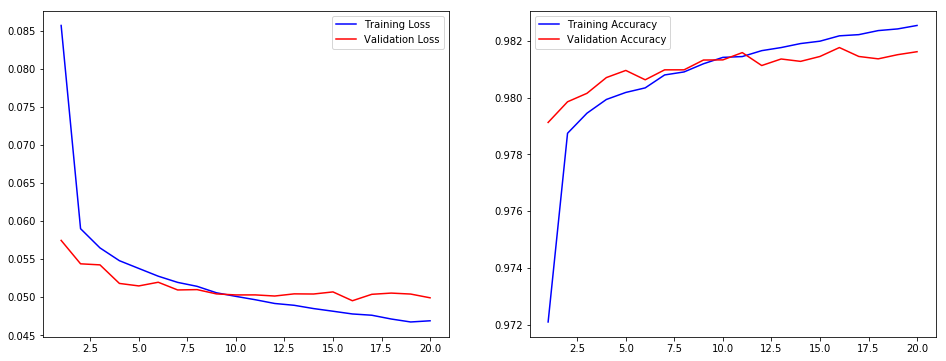

In [87]:
plot_metrics(history)